# N-Armed Bandit

Luis Ramírez Guzmán

A01638402

Se usa un agente epsilon-greedy para resolver el problema.

Inicializa el problema con n máquinas que dan recompensas de manera estocástica y un agente capaz de ejecutar una operación de captación de la recompensa misma de las máquinas por ronda. La recompensa está medida por el porcentaje de éxito que reporte cada máquina, donde por máquina, en cada evento puede haber solo éxito o fracaso.

In [1]:
import numpy as np
import matplotlib.pyplot as plt

In [2]:
class Environment:
    
    #Inicializar ambiente con un arreglo de probabilidades para las n máquinas
    def __init__(self, probs):
        self.probs = probs
        
    #Tomar una muestra de una de las máquinas (proceso estocástico)
    def step(self, action):
        if np.random.random() < self.probs[action]:
            return 1
        return 0

In [3]:
class Agent:
    
    #Inicializar un agente con un número de acciones y un epsilon-greedy
    def __init__(self, n_actions, epsilon):
        self.n_actions = n_actions
        self.epsilon = epsilon
        
        #Número de veces que las acciones han sucedido
        self.n = np.zeros(n_actions, dtype=np.int)
        
        #Valor estimado de cada acción
        self.Q = np.zeros(n_actions, dtype=np.float)
        
    #Actualizar el valor de una acción dada ésta y su correspondiente recompensa
    def update(self, action, reward):
        
        #Contar que sucedió la acción
        self.n[action] += 1
        
        #Actualizar el valor ponderado de la acción
        self.Q[action] += (1 / self.n[action]) * (reward - self.Q[action])
        
    #Elegir una acción basada en el comportamiento epsilon-greedy
    def choose(self):
        #Explorar
        if np.random.random() < self.epsilon:
            return np.random.randint(self.n_actions)
        #Explotar
        else:
            return np.random.choice(np.flatnonzero(self.Q == self.Q.max()))

Un experimento singular se define, en una especie de pseudocódigo, de la siguiente manera:

Se inicializan el ambiente y el agente con las probabilidades de los estados y se le introduce el epsilon al agente, esté será su valor durante todo el experimento. Se inicializan vacíos los históricos de acciones, recompensas y de cumplimiento de la condición de selección de máquina óptima.

Para cada punto en el tiempo o paso (step) el agente elige una acción (un número de 0 al número de probabilidades que describen las máquinas) y captura del ambiente una recompensa por la acción que acaba de seleccionar.

Posteriormente, se revisa si la acción elegida fue en efecto la óptima y se agrega al registro. Este será uno de los resultados del algoritmo. Lueg, el agente actualiza su valoración de la máquina que recién uso a partir de la recompensa que obtuvo. 

Por último, la acción seleccionada y la recompensa obtenida pasan al histórico. 

In [4]:
#Experimento con probabilidades y número de épocas
def experiment(probs, epochs, epsilon):
    #Inicilizar ambiente y agente
    env = Environment(probs)
    agent = Agent(len(env.probs), epsilon)
    
    #Llevar cuenta de acciones y recompensas
    actions, rewards = [], []
    optimal = []
    
    #Generar episodios de elección y percepción de recompensa
    for epcoh in range(epochs):
        action = agent.choose()
        reward = env.step(action)
        
        #Check if action is optimal
        is_optimal = np.argmax(env.probs) == action
        optimal.append(is_optimal)
        
        #Actualizar valor esperado de acción
        agent.update(action, reward)
        
        #Actualizar registro
        actions.append(action)
        rewards.append(reward)
        
    
    return np.array(actions), np.array(rewards), np.array(optimal)

Hasta ahora, ya está todo lo necesario para correr un experimento del N-Armed Bandit, mas ahora nos gustaría correr varios para obtener el valor esperado de las recompensas que tendríamos para el escenario particular que creamos gracias a las probabilidades de éxito para cada una de las acciones.

A continuación se define N como el número de veces que se harán los experimentos y se almacenará un histórico de acciones y recompensas, así como en la función experimento; en esta ocasión cada uno de los resultados del experimento se almacenará para llegar finalmente al valor esperado. Todo se mostrará en las gráficas de acciones y recompensa promedio.

In [5]:
#Probabiidades de las máquinas
probs = [0.1, 0.5, 0.42, 0.3, 0.09,
        0.2, 0.8, 0.49, 0.29, 0.3]

#Número de experimentos y episodios por experimento
N = 10000
epochs = 500

#Parámetro epsilon-greedy
eps = 0.10

Se repite la función de experimento N veces con el fin de obtener una recompensa estimada y su visaulización con claridad. También se registra un historial de las recompensas y de las acciones tomadas.

In [6]:
#Experimentos

#Inicializar históricos de recompensas y acciones y cuenta de seleción de acción óptima

def replicate(N, probs, epochs, eps):
    R = np.zeros((epochs,))  
    A = np.zeros((epochs, len(probs)))  
    O = np.zeros((epochs,))
    for i in range(N):
        actions, rewards, optimal = experiment(probs, epochs, eps)
        R += rewards
        O += optimal
        for j, a in enumerate(actions):
            A[j][a] += 1
            
    return R, A, O

In [7]:
R, A, O = replicate(N, probs, epochs, eps)

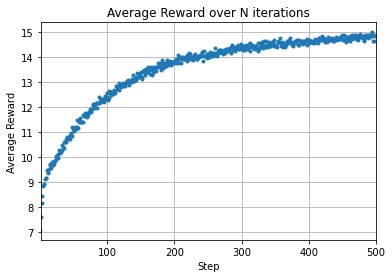

In [8]:
R_avg =  R / np.float(epochs)
plt.plot(R_avg, ".")
plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.grid()
ax = plt.gca()
plt.title('Average Reward over N iterations')
plt.xlim([1, epochs])
plt.show()

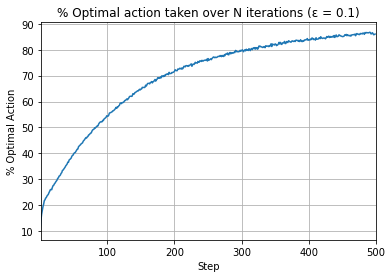

In [9]:
O_avg = (O / np.float(N)) * 100
plt.plot(O_avg)
plt.xlabel("Step")
plt.ylabel("% Optimal Action")
plt.grid()
ax = plt.gca()
plt.title(f'% Optimal action taken over N iterations (\u03B5 = {eps})')
plt.xlim([1, epochs])
plt.show()


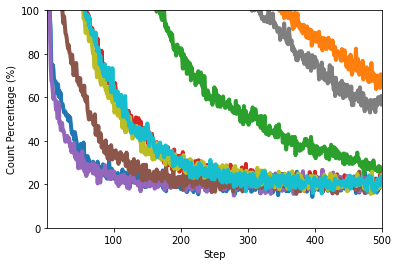

In [10]:
for i in range(len(probs)):
    A_pct = 100 * A[:,i] / epochs
    steps = list(np.array(range(len(A_pct)))+1)
    plt.plot(steps, A_pct, "-",
             linewidth=4,
             label="Arm {} ({:.0f}%)".format(i+1, 100*probs[i]))
plt.xlabel("Step")
plt.ylabel("Count Percentage (%)")
plt.xlim([1, epochs])
plt.ylim([0, 100])
plt.show()

In [11]:
epsilons = [0.5, 0.2, 0.1, 0.05]

R_e_averages = []
O_e_averages = []


for e in epsilons:
    R_e, A_e, O_e = replicate(N, probs, epochs, e)
    R_e_averages.append(R_e / np.float(epochs))
    O_e_averages.append((O_e / np.float(N)) * 100)

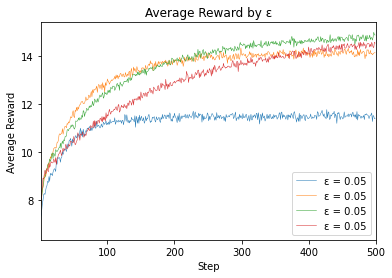

In [12]:
for R_e_avg in R_e_averages:
    plt.plot(R_e_avg, linewidth=0.5, label=f'\u03B5 = {e}')

plt.xlabel("Step")
plt.ylabel("Average Reward")
plt.title('Average Reward by \u03B5')
plt.xlim([1, epochs])
plt.legend()
plt.show()

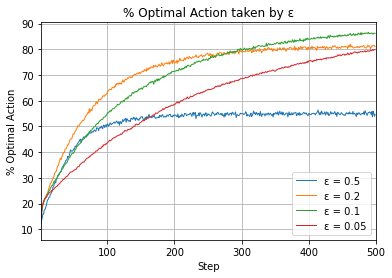

In [14]:
for i, O_e_avg in enumerate(O_e_averages):
    plt.plot(O_e_avg, linewidth=1, label=f'\u03B5 = {epsilons[i]}')
    
plt.xlabel("Step")
plt.ylabel("% Optimal Action")
plt.title("% Optimal Action taken by \u03B5")
plt.grid()
plt.xlim([1, epochs])
plt.legend()
plt.show()